**Loading the Spambase data for Decision Tree and Neural Network Analysis**


In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spambase = pd.read_csv('spambase.csv')

print("Spambase loaded.")

Spambase loaded.


**Loaded 'Spambase' will be used to evaluate an	_Unpruned Decision Tree_ using _10-fold cross-validation_. For that 'spam_class' has been dropped for prediction analysis. After prediction, ROC curve will be generated and Accuracy for decision tree will be calculated.**


Acc, TPR, FPR =  0.9169745707454902 0.8990623276337562 0.07137733142037303

Accuracy on Unprunned Decision tree 0.91697585589

AUC 0.91375019646


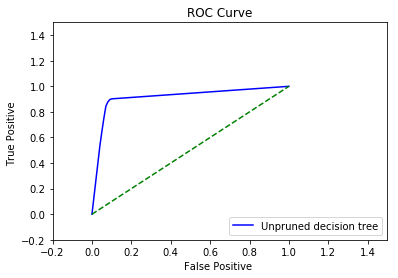

In [222]:
# STEP 2 from the asignment


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from scipy import interp

# Copy spambase across and drop spam_class (we don't include the class feature in the training data)


X_df = spambase
X_df = X_df.drop('spam_class', axis=1)

column = X_df.shape[1]
# print (column)
X = np.ravel(X_df).reshape(4601, 57)

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

# now split the data into training data and test data (80/20 split)
# random_state = k sets a specific random seed
# since random_state is fixed, this call will always produce the same split
# if you leave out the random_state value, you will get a different random split when you run it agaimn
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


clf_gini = DecisionTreeClassifier()
#     criterion = "gini", random_state = 100,                               max_depth=3, min_samples_leaf=5)

k=10
kf = KFold(n_splits=k, shuffle=True, random_state=None)

tp = 0
fp = 0
tn = 0
fn = 0

y_roc=[]
y_te_roc=[]
y_acc=[]


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    unprun_dcsn_tree = clf_gini.fit(X_tr, y_tr)

    y_te_pred = unprun_dcsn_tree.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
    
    fpr, tpr, thresholds = roc_curve(y_te, y_te_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    
    i=i+1

#     y_te_pred = lr.predict(X_te)
 
    # compute confusion matrix statistics
    j = 0
    while (j < len(y_te)):
        if (y_te_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1        
        j = j + 1
     
    

acc = (tp+tn)/len(y)
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

print("\nAcc, TPR, FPR = ", acc, tpr, fpr)

avg_acc= np.array(y_acc)

print("\nAccuracy on Unprunned Decision tree",np.mean(avg_acc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr,'b',label='Unpruned decision tree')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)

# print ("AUC for decision tree:", roc_auc)

# plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos, true_pos,'b',label='unpruned')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.5])
plt.ylim([-0.2,1.5])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()


**For prunning the decision tree, best _level_ of prunning will be calculated within range of trees**

In [223]:
# STEP 3 from the assignment

best_rss = float("infinity")
for i in range(1,57):
    clf_gini = DecisionTreeClassifier(max_depth=i)
    rss_sum=0

    for (train_index, test_index) in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]


    #     clf_gini = DecisionTreeClassifier(max_depth=50)
        unprun_dcsn_tree = clf_gini.fit(X_tr, y_tr)

        y_te_pred = unprun_dcsn_tree.predict(X_te)

        y_acc.append(accuracy_score(y_te,y_te_pred))

#         print ("Accuracy in decision tree in i ",i," :" ,accuracy_score(y_te,y_te_pred))


        y_roc.extend(y_te_pred)
        y_te_roc.extend(y_te)

        rss = sum((y_te_pred-y_te)**2)
        rss_sum = rss_sum + rss

    if (rss_sum < best_rss):
        best_level = i
        best_rss = rss_sum

avg_acc= np.array(y_acc)

print("\nAccuracy on Unprunned Decision tree",np.mean(avg_acc))

    
print("Best Pruning level = ", best_level)


Accuracy on Unprunned Decision tree 0.912906087486
Best Pruning level =  11


** Using the _best prunning level_ from prior analysis, decision tree classifier will be used according to that. Evaluation will be done with Accuracy and ROC curve plot.**


Accuracy on Prunned Decision tree at level  11 is:  0.913088553337

AUC 0.915525848263


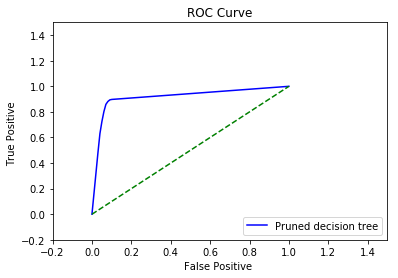

In [224]:
# STEP 4 of assignment 

clf_gini = DecisionTreeClassifier(max_depth=best_level)

i=0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    unprun_dcsn_tree = clf_gini.fit(X_tr, y_tr)

    y_te_pred = unprun_dcsn_tree.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
      
    fpr, tpr, thresholds = roc_curve(y_te, y_te_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    i+=1
    

avg_acc= np.array(y_acc)

print("\nAccuracy on Prunned Decision tree at level ",best_level,"is: ",np.mean(avg_acc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

false_pos_PRUN = mean_fpr
true_pos_PRUN = mean_tpr


plt.plot(mean_fpr, mean_tpr,'b',label='Pruned decision tree')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)


# false_pos_PRUN, true_pos_PRUN, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos_PRUN, true_pos_PRUN)
# print ("\nAUC", auc_0)

# print ("AUC for decision tree:", roc_auc)

# plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos_PRUN, true_pos_PRUN,'b',label='pruned')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.5])
plt.ylim([-0.2,1.5])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()


** Bagged Decision Tree analysis will be done over unprunned situation using 50 Trees. Accuracy and Area Under Curve(AUC) will also be calculated. **


Accuracy on Bagged decision tree is:  0.913648024144

AUC 0.924177817058


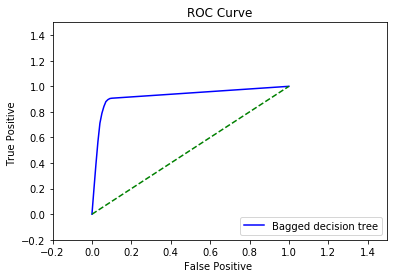

In [225]:
# STEP  of assignment 
# Bagged Decision Trees for Classification


from sklearn.ensemble import BaggingClassifier

num_trees = 50
clf_gini = DecisionTreeClassifier()

bag_dcsn_tree = BaggingClassifier(base_estimator=clf_gini, n_estimators=num_trees)

i=0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    unprun_dcsn_tree = bag_dcsn_tree.fit(X_tr, y_tr)

    y_te_pred = unprun_dcsn_tree.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
    fpr, tpr, thresholds = roc_curve(y_te, y_te_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    i+=1
    

#     y_te_pred = lr.predict(X_te)
 

avg_acc= np.array(y_acc)

print("\nAccuracy on Bagged decision tree is: ",np.mean(avg_acc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)


false_pos_BAG = mean_fpr
true_pos_BAG = mean_tpr

plt.plot(mean_fpr, mean_tpr,'b',label='Bagged decision tree')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)


# false_pos_BAG, true_pos_BAG, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos_BAG, true_pos_BAG)
# print ("\nAUC", auc_0)

# # print ("AUC for decision tree:", roc_auc)

# # plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos_BAG, true_pos_BAG,'b',label='Bagged')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.5])
plt.ylim([-0.2,1.5])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()


** Boosted Decision Tree analysis will be done over unprunned situation. With _10-Fold Cross Validation_ Accuracy and Area Under Curve(AUC) will also be calculated. **


Accuracy on Boosted decision tree is:  0.914167146091

AUC 0.928042170512


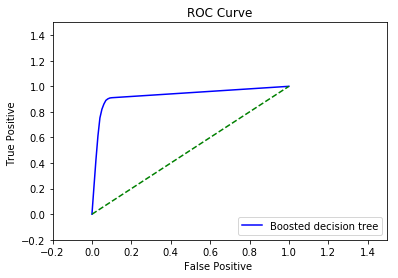

In [226]:
# STEP 6 of assignment


from sklearn.ensemble import AdaBoostClassifier

num_trees = 25
clf_gini = DecisionTreeClassifier()

boost_dcsn_tree = AdaBoostClassifier(base_estimator=clf_gini, n_estimators=num_trees)

i=0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    unprun_dcsn_tree = boost_dcsn_tree.fit(X_tr, y_tr)

    y_te_pred = unprun_dcsn_tree.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
    fpr, tpr, thresholds = roc_curve(y_te, y_te_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i+=1
    

#     y_te_pred = lr.predict(X_te)
 

avg_acc= np.array(y_acc)

print("\nAccuracy on Boosted decision tree is: ",np.mean(avg_acc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

false_pos_BOST = mean_fpr
true_pos_BOST = mean_tpr

plt.plot(mean_fpr, mean_tpr,'b',label='Boosted decision tree')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)

# false_pos_BOST, true_pos_BOST, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos_BOST, true_pos_BOST)
# print ("\nAUC", auc_0)

# # print ("AUC for decision tree:", roc_auc)

# # plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos_BOST, true_pos_BOST,'b',label='Boosted ')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.5])
plt.ylim([-0.2,1.5])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()


** Random Forest analysis will be done with _10-Fold Cross Validation_ using 100 trees. Classifier Accuracy and Area Under Curve(AUC) will also be calculated. **


Accuracy on Random Forest is:  0.914818880521

AUC 0.932294532142


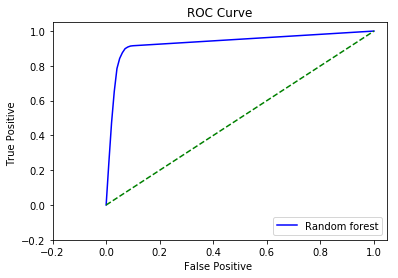

In [227]:
#  STEP 7 of assginment


from sklearn.ensemble import RandomForestClassifier

num_trees = 100

rand_forest = RandomForestClassifier(n_estimators=num_trees)

i=0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    unprun_dcsn_tree = rand_forest.fit(X_tr, y_tr)

    y_te_pred = unprun_dcsn_tree.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
    fpr, tpr, thresholds = roc_curve(y_te, y_te_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i+=1

#     y_te_pred = lr.predict(X_te)
 

avg_acc= np.array(y_acc)

print("\nAccuracy on Random Forest is: ",np.mean(avg_acc))



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

false_pos_RF = mean_fpr
true_pos_RF = mean_tpr

plt.plot(mean_fpr, mean_tpr,'b',label='Random forest')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)


# false_pos_RF, true_pos_RF, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos_RF, true_pos_RF)
# print ("\nAUC", auc_0)

# # print ("AUC for decision tree:", roc_auc)

# # plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos_RF, true_pos_RF,'b',label='Random Forest')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.05])
plt.ylim([-0.2,1.05])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()


** A combination of Decision Tree Prunning, Bagged Decision Tree, Boosted Decision Tree and Random Forest analysis will be showcased by ROC curve in the same graph space. **For every classifier 10-Fold Cross Vaalidatin has been used.

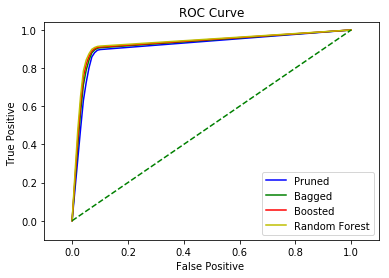

In [228]:
# STEP 8 of assignment

plt.plot(false_pos_PRUN, true_pos_PRUN,'b',label='Pruned')

plt.plot(false_pos_BAG, true_pos_BAG,'g',label='Bagged')

plt.plot(false_pos_BOST, true_pos_BOST,'r',label='Boosted ')

plt.plot(false_pos_RF, true_pos_RF,'y',label='Random Forest')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.04])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()



** Using Single Hidden Layer neural network '_Spambase_' dataset has been analyzed by changing size of the neurons in input. **

First, _Same number of neurons_ will be used. With the 10-Fold Cross Validation, accuracy and ROC Crve will be generated.


Accuracy on Single Hidden Layer is:  0.914713448415

AUC 0.927239916046


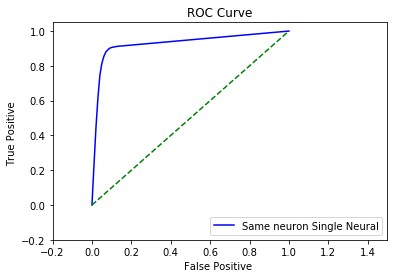

In [229]:
from sklearn.neural_network import MLPClassifier


single_neural = MLPClassifier(hidden_layer_sizes=(column,))

i=0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    hidden_layer = single_neural.fit(X_tr, y_tr)

    y_te_pred = hidden_layer.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
    fpr, tpr, thresholds = roc_curve(y_te, y_te_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    i+=1

#     y_te_pred = lr.predict(X_te)
 

avg_acc= np.array(y_acc)

print("\nAccuracy on Single Hidden Layer is: ",np.mean(avg_acc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# false_pos_RF = mean_fpr
# true_pos_RF = mean_tpr

plt.plot(mean_fpr, mean_tpr,'b',label='Same neuron Single Neural')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)


# false_pos_N, true_pos_N, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos_N, true_pos_N)
# print ("\nAUC", auc_0)

# # print ("AUC for decision tree:", roc_auc)

# # plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos_N, true_pos_N,'b',label='Same Single Neural')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.5])
plt.ylim([-0.2,1.05])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()

# 0.908734581341
# 0.906208463014

_Number of Neuron Doubled_ for calculating accuracy and ROC Curve.


Accuracy on Single Hidden Layer is:  0.914414631079

AUC 0.921622221906


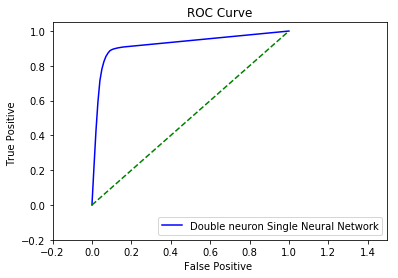

In [230]:


single_neural = MLPClassifier(hidden_layer_sizes=(column*2,))

i=0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    hidden_layer = single_neural.fit(X_tr, y_tr)

    y_te_pred = hidden_layer.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
    fpr, tpr, thresholds = roc_curve(y_te, y_te_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i+=1

#     y_te_pred = lr.predict(X_te)
 

avg_acc= np.array(y_acc)

print("\nAccuracy on Single Hidden Layer is: ",np.mean(avg_acc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# false_pos_RF = mean_fpr
# true_pos_RF = mean_tpr

plt.plot(mean_fpr, mean_tpr,'b',label='Double neuron Single Neural Network')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)


# false_pos_2N, true_pos_2N, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos_2N, true_pos_2N)
# print ("\nAUC", auc_0)

# # print ("AUC for decision tree:", roc_auc)

# # plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos_2N, true_pos_2N,'b',label='Double Single Neural')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.5])
plt.ylim([-0.2,1.05])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()

# 0.908734581341
# 0.906208463014

_Half number of neurons_ will be used for analyzing difference in accuracy and Area Under Curve(AUC).


Accuracy on Single Hidden Layer is:  0.914288143686

AUC 0.921622221906


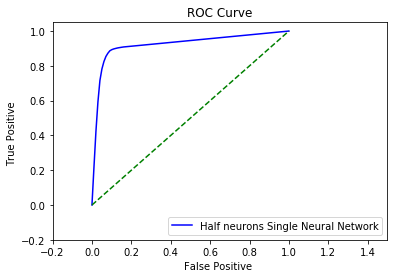

In [231]:

single_neural = MLPClassifier(hidden_layer_sizes=(int((column/2)*10),))

i=0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    hidden_layer = single_neural.fit(X_tr, y_tr)

    y_te_pred = hidden_layer.predict(X_te)
   
    y_acc.append(accuracy_score(y_te,y_te_pred))
    
#     print ("Accuracy in decision tree is ", accuracy_score(y_te,y_te_pred))
    
    y_roc.extend(y_te_pred)
    y_te_roc.extend(y_te)
    
    i+=1
    

#     y_te_pred = lr.predict(X_te)
 

avg_acc= np.array(y_acc)

print("\nAccuracy on Single Hidden Layer is: ",np.mean(avg_acc))


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

false_pos_RF = mean_fpr
true_pos_RF = mean_tpr

plt.plot(mean_fpr, mean_tpr,'b',label='Half neurons Single Neural Network')

# false_pos, true_pos, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos, true_pos)
print ("\nAUC", mean_auc)

# false_pos_n, true_pos_n, thres = roc_curve(y_te_roc, y_roc)

# auc_0 = auc(false_pos_n, true_pos_n)
# print ("\nAUC", auc_0)

# # print ("AUC for decision tree:", roc_auc)

# # plt.plot(fpr, tpr,'b',label='unpruned')
# plt.plot(false_pos_n, true_pos_n,'b',label='Half Single Neural')

# y_pred_1 = logres_1.fit(X_train_1, y_train_1).decision_function(X_test_1)    
# false_pos_1, true_pos_1, thres_1 = roc_curve(y_test_1, y_pred_1)
# # roc_auc_1 = auc(false_pos_1, true_pos_1)

# plt.plot(false_pos_1, true_pos_1,'r',label='logres1')

plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
plt.xlim([-0.2,1.5])
plt.ylim([-0.2,1.05])
plt.ylabel('True Positive ')
plt.xlabel('False Positive ')
plt.show()

# 0.908734581341
# 0.906208463014